In [ ]:
#Primero conectemos la maquina virtual con el drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Los datos para correr este código se encuentran en la unidad compartida del grupo GENSyR (Grupo de estudio de neurociencia, sistemas y redes), si ya está ingresadx en el drive podrá correr el codigo sin problemas

#las siguientes dos lineas son para acceder al drive en la maquina virtual

In [ ]:
cd /gdrive/Shareddrives/GENSyR /Neurofísica/Proyecto lesiones

/gdrive/Shareddrives/GENSyR /Neurofísica/Proyecto lesiones


In [ ]:
ls

 AAL.csv
 AAL_space-MNI152NLin6_res-1x1x1.nii.gz
'Conectividad funcional'/
'EDA Estructurales y funcionales- Hubs.ipynb'
 estructural_hammersmith.npy
 Estructural_Promedio.npy
 funcional_hammersmith.npy
 Funcional_Promedio.npy
 Hammersmith2.csv.gsheet
 Hammersmith.csv
 Hammersmith.gsheet
 initial_condition.bin
'Ising - Entropia '/
'LESIONES - RESULTADOS'/
 M2final.npy
 matriz_promedio_threshold265.xlsx
 medidas2.csv
 medidas2.gsheet
 medidas3.csv
 medidas.csv
 medidas_estructural_promedio.csv
 medidas_estructural_promedio_WEITHG.csv
 medidas_estructural_sinlog.csv
 medidas_estructural_sinlog_pesado.csv
 medidas_funcional.csv
 medidas_funcional_promedio_0.6.csv
 medidas_funcional_threshold.csv
 medidas.xlsx
 Mfinal.npy
 otronombre.csv
'Redes Estructurales y funcionales- Hubs.ipynb'
'Redes Funcionales - Hubs.ipynb'
 restingstate_functionalconnectivity.npy
 Tractografia/
 Untitled
'Untitled0 (1).ipynb'
 Untitled0.ipynb


In [ ]:
#se importan librerias y se cargan las matrices con numpy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
#carguemos las matrices estructural y funcional
estructural1 = np.load("estructural_hammersmith.npy")
funcional = np.load("funcional_hammersmith.npy")
# dada la gran diferencia en cantidad de tractos es necesario aplicar el logaritmo para linealizar los datos
estructural = np.log1p(estructural1)
#Se hace la diagonal igual a 0 para las dos matrices 
for i in range(len(estructural)-1):
  estructural[i+1][i+1] = 0
  funcional[i][i] = 0

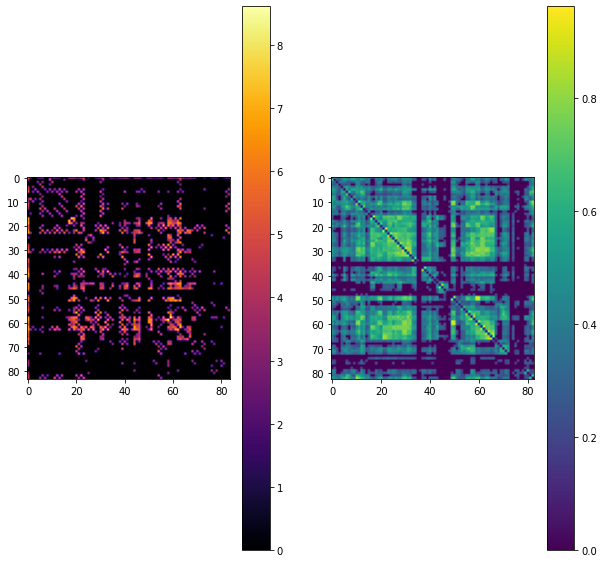

In [ ]:
#Definamos el threshold que se le aplicará a las matrices
estructural_threshold = 3
funcional_threshold = 0.2

#apliquemos el threshold
estruc = estructural*(estructural > estructural_threshold)
func = funcional*(funcional > funcional_threshold)
#ploteemos
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(estruc,cmap = "inferno")
plt.colorbar()
plt.subplot(122)
plt.imshow(func)
plt.colorbar()


In [ ]:
#Ahora creemos los grafos a partir de las matrices
gestructural = nx.convert_matrix.from_numpy_array(estruc)
gfuncional = nx.convert_matrix.from_numpy_array(func)

gestructural.remove_node(0) #quitamos la parcela "null" de la red estructural

#Comprobamos que los dos grafos sean pesados
print(nx.is_weighted(gfuncional),nx.is_weighted(gestructural))

True True


In [ ]:
#Ahora leamos el archivo con los labels correspondientes a esta parcelación, este archivo también está en el Drive de GENSyR
#labelcsv = pd.read_csv("AAL.csv")
labelcsv = pd.read_csv("Hammersmith.csv")

In [ ]:
def plothubs(Grafo,n_ranking,rank,medida,min_color,labelcsv):
  """
  n_ranking: número de nodos a los que se les mostrará el nombre y se les cambiara el color
  rank: nombre de la medida que define el ranking (grafo, intermediacion, eigenvector, clusterizacion) o ingrese directamente el diccionario con la medida producto de networkx
  medida: nombre de la medida que define el tamaño del os nodos, mismos nombres posibles que en rank o ingrese directamente el diccionario con la medida producto de networkx
  """
  grafo = Grafo.copy()
  if rank == "grado":
    rank = nx.degree_centrality(grafo)
  if rank == "intermediacion":
    rank = nx.betweenness_centrality(grafo)
  if rank == "eigenvector":
    rank = nx.eigenvector_centrality(grafo)
  if rank == "clusterizacion":
    rank = nx.clustering(grafo)
  if medida == "grado":
    medida = nx.degree_centrality(grafo)
  if medida == "intermediacion":
    medida = nx.betweenness_centrality(grafo)
  if medida == "eigenvector":
    medida = nx.eigenvector_centrality(grafo)
  if medida == "clusterizacion":
    medida = nx.clustering(grafo)
  lista = list(rank.values())
  lista.sort()
  #Ponemos los labels al grafo
  colors = np.ones((len(grafo.nodes())))*min_color
  top = []
  for i in range(len(grafo.nodes())):
    if rank[i+1] >= lista[len(lista)-n_ranking]:
      colors[i] = 1
      prueba = { i+1 : labelcsv.values[i][1]}
      top.append(labelcsv.values[i][1])
      grafo = nx.relabel_nodes(grafo,prueba)
  plt.figure(figsize=(16,16))
  nx.draw_kamada_kawai(grafo, node_size = [medida[i]*200000 for i in Grafo.nodes()], with_labels = True, node_color = colors, vmin = 0, vmax = 1)
  plt.show()
  print(top)
  return;

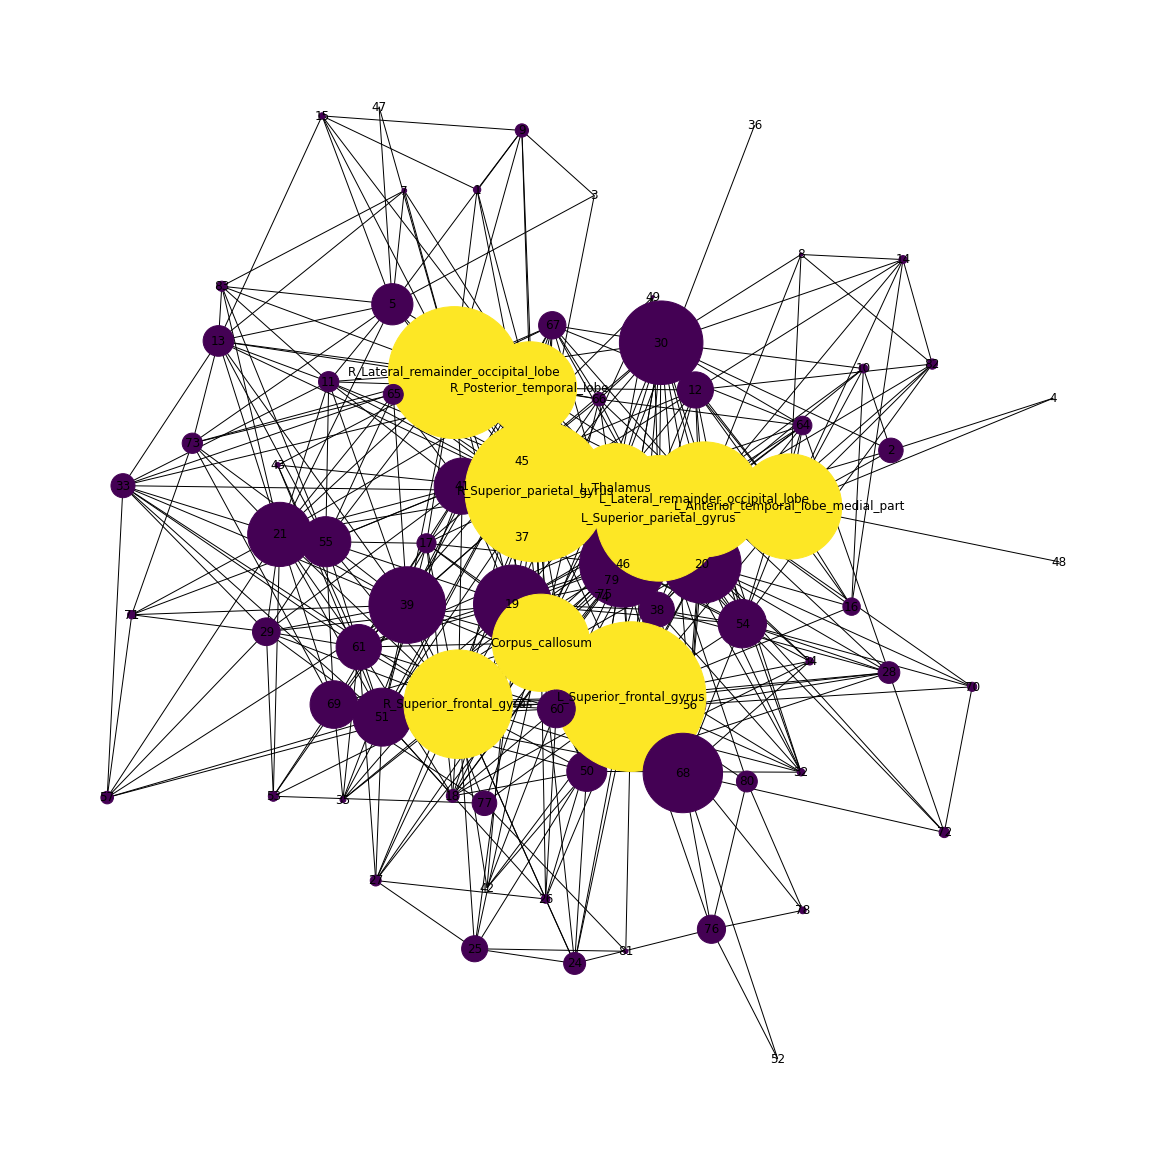

['L_Anterior_temporal_lobe_medial_part', 'L_Lateral_remainder_occipital_lobe', 'R_Lateral_remainder_occipital_lobe', 'R_Posterior_temporal_lobe', 'L_Thalamus', 'Corpus_callosum', 'L_Superior_frontal_gyrus', 'R_Superior_frontal_gyrus', 'L_Superior_parietal_gyrus', 'R_Superior_parietal_gyrus']


In [ ]:
plothubs(gestructural,10,"intermediacion","intermediacion",0)

In [ ]:
def plotmedidas(Grafo,medidarank):
  grafo = Grafo.copy()
  #removemos los nodos isolados para calcular las medidas
  grafo.remove_nodes_from(list(nx.isolates(grafo)))
  # Las medidas planteadas en el trabajo para hallar los hubs son bastante estándar, razón por la cual Networkx incorpora funciones para calcularlas de forma muy sencilla

  #Medidas de integración 
  grado = nx.degree_centrality(grafo)
  intermediacion = nx.betweenness_centrality(grafo)
  comunicabilidad = nx.communicability(grafo)
  eigenvector = nx.eigenvector_centrality(grafo)

  #Medida de segregación
  clusterización = nx.clustering(grafo)

  #la estructura de datos de las medidas es un diccionario, el cual contiene unas llaves y unos valores asociados a esas llaves

  #Ahora se extraeran los valores
  deg = list(grado.values())

  inter = list(intermediacion.values())

  eigen = list(eigenvector.values())

  clust = list(clusterización.values())

  com = []

  #la comunicabilidad es una medida para cada par de nodos, en este caso lo que se está haciendo es tomar la comunicabilidad del nodo i como la suma de sus comunicabilidades
  #con todos los otros nodos
  for i in comunicabilidad.keys():
    sum = 0
    for j in comunicabilidad[i].keys():
      sum = sum + comunicabilidad[i][j]
    com.append(sum)
  #normalicemos la medida para que esté entre 0 y 1
  a = np.max(com)
  com = com/a
  #reorganicemos las medidas para que queden de mayor a menor grado
  deg2 = deg.copy()
  inter2=inter.copy()
  eigen2=eigen.copy()
  clust2=clust.copy()
  com2 = com.copy()
  indexs = []
  if medidarank == "grado":
    rank = deg
    rank_orden = rank.copy()
    rank_orden.sort()
    for i in rank_orden:
      indexs.append(rank.index(i))
    for i in range(len(inter)):
      inter2[i] = inter[indexs[i]]
    for i in range(len(clust)):
      clust2[i] = clust[indexs[i]]
    for i in range(len(eigen)):
      eigen2[i] = eigen[indexs[i]]
    for i in range(len(com)):
      com2[i] = com[indexs[i]]
  if medidarank == "intermediacion":
    rank = inter
    rank_orden = rank.copy()
    rank_orden.sort()
    for i in rank_orden:
      indexs.append(rank.index(i))
    for i in range(len(inter)):
      inter2[i] = inter[indexs[i]]
    for i in range(len(clust)):
      clust2[i] = clust[indexs[i]]
    for i in range(len(eigen)):
      eigen2[i] = eigen[indexs[i]]
    for i in range(len(com)):
      com2[i] = com[indexs[i]]
  if medidarank == "eigenvector":
    rank = eigen
    rank_orden = rank.copy()
    rank_orden.sort()
    for i in rank_orden:
      indexs.append(rank.index(i))
    for i in range(len(inter)):
      inter2[i] = inter[indexs[i]]
    for i in range(len(clust)):
      clust2[i] = clust[indexs[i]]
    for i in range(len(eigen)):
      eigen2[i] = eigen[indexs[i]]
    for i in range(len(com)):
      com2[i] = com[indexs[i]]
  if medidarank == "clusterizacion":
    rank = clust
    rank_orden = rank.copy()
    rank_orden.sort()
    for i in rank_orden:
      indexs.append(rank.index(i))
    for i in range(len(inter)):
      inter2[i] = inter[indexs[i]]
    for i in range(len(clust)):
      clust2[i] = clust[indexs[i]]
    for i in range(len(eigen)):
      eigen2[i] = eigen[indexs[i]]
    for i in range(len(com)):
      com2[i] = com[indexs[i]]
  plt.figure(figsize=(10,10))
  plt.subplot(321)
  plt.plot(deg2)
  plt.title("grado")
  plt.subplot(322)
  plt.plot(inter2)
  plt.title("intermediacion")
  plt.subplot(323)
  plt.plot(clust2)
  plt.title("clusterizacion")
  plt.subplot(324)
  plt.plot(eigen2)
  plt.title("eigenvector")
  plt.subplot(325)
  plt.plot(com2)
  plt.title("comunicabilidad")
  plt.show()
  return;

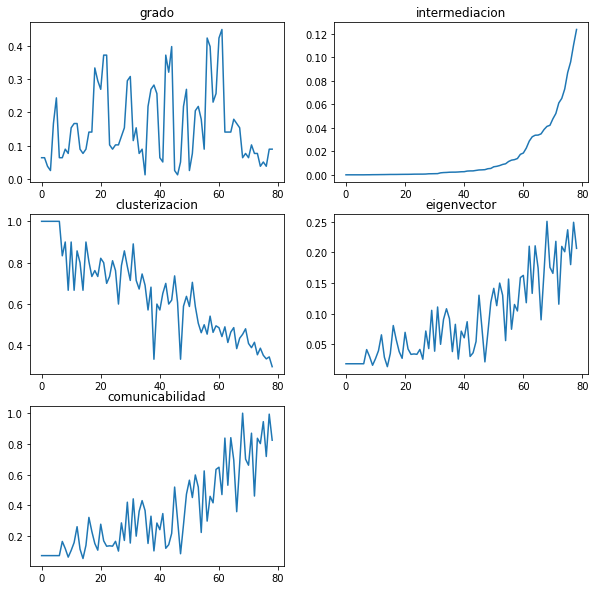

In [ ]:
plotmedidas(gestructural,"intermediacion")

In [ ]:
grado = nx.clustering(gfuncional)
exampleDict = grado
import operator
sortedDict = sorted(exampleDict.items(), key=operator.itemgetter(1))
print(sortedDict)

[(35, 0), (36, 0), (73, 0), (77, 0), (58, 0.7877477477477477), (12, 0.8125978090766823), (46, 0.8172043010752689), (57, 0.8207762557077626), (48, 0.8222222222222222), (53, 0.8248447204968944), (79, 0.8294898672257163), (1, 0.8386946386946387), (25, 0.8390342052313883), (80, 0.8452380952380952), (71, 0.8463768115942029), (32, 0.8490945674044266), (50, 0.8525149190110827), (0, 0.8538302277432712), (34, 0.854326923076923), (29, 0.854728370221328), (10, 0.8596273291925466), (60, 0.8597612958226769), (72, 0.862937062937063), (24, 0.8648763853367434), (27, 0.8648763853367434), (28, 0.8648763853367434), (6, 0.8653846153846154), (13, 0.865424430641822), (82, 0.8687127024722933), (51, 0.8690196078431373), (23, 0.8691834942932397), (20, 0.8699792960662526), (30, 0.8703933747412008), (31, 0.8703933747412008), (67, 0.8735576923076923), (65, 0.8746694870438921), (61, 0.8751696065128901), (62, 0.8751696065128901), (56, 0.877431026684758), (11, 0.8784021071115014), (8, 0.879692446856626), (81, 0.8798